In [25]:
from firedrake import *
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [26]:
mesh = UnitSquareMesh(40, 40, quadrilateral=True)


V = FunctionSpace(mesh, "DQ", 1)
W = VectorFunctionSpace(mesh, "CG", 1)


x, y = SpatialCoordinate(mesh)

r = sqrt(pow(x-0.5, 2) + pow(y-0.5, 2))

velocity = as_vector(( (0.5 - y) , (x - 0.5) ))
u = Function(W).interpolate(velocity)


bell_r0 = 0.15; bell_x0 = 0.25; bell_y0 = 0.5
cone_r0 = 0.15; cone_x0 = 0.5; cone_y0 = 0.25
cyl_r0 = 0.15; cyl_x0 = 0.5; cyl_y0 = 0.75
slot_left = 0.475; slot_right = 0.525; slot_top = 0.85

bell = 0.25*(1+cos(math.pi*min_value(sqrt(pow(x-bell_x0, 2) + pow(y-bell_y0, 2))/bell_r0, 1.0)))
cone = 1.0 - min_value(sqrt(pow(x-cone_x0, 2) + pow(y-cone_y0, 2))/cyl_r0, 1.0)
slot_cyl = conditional(sqrt(pow(x-cyl_x0, 2) + pow(y-cyl_y0, 2)) < cyl_r0,
             conditional(And(And(x > slot_left, x < slot_right), y < slot_top),
               0.0, 1.0), 0.0)

In [27]:
q = Function(V).interpolate(1.0 + bell + cone + slot_cyl)
q_init = Function(V).assign(q)

qs = []

T = 2*math.pi
dt = T/1200
dtc = Constant(dt)
q_in = Constant(1.0)

dq_trial = TrialFunction(V)
phi = TestFunction(V)
a = phi*dq_trial*dx

n = FacetNormal(mesh)
un = 0.5*(dot(u, n) + abs(dot(u, n)))

L1 = dtc*(q*div(phi*u)*dx
          - conditional(dot(u, n) < 0, phi*dot(u, n)*q_in, 0.0)*ds
          - conditional(dot(u, n) > 0, phi*dot(u, n)*q, 0.0)*ds
          - (phi('+') - phi('-'))*(un('+')*q('+') - un('-')*q('-'))*dS)


q1 = Function(V); q2 = Function(V)
L2 = replace(L1, {q: q1}); L3 = replace(L1, {q: q2})

dq = Function(V)

In [28]:

params = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
prob1 = LinearVariationalProblem(a, L1, dq)
solv1 = LinearVariationalSolver(prob1, solver_parameters=params)
prob2 = LinearVariationalProblem(a, L2, dq)
solv2 = LinearVariationalSolver(prob2, solver_parameters=params)
prob3 = LinearVariationalProblem(a, L3, dq)
solv3 = LinearVariationalSolver(prob3, solver_parameters=params)


In [29]:
#Set limiter
limiter = VertexBasedLimiter(V)

t = 0.0
step = 0
output_freq = 20
#Apply it first to q
#limiter.apply(q)

#bad limiter for each stage.
DG0 = FunctionSpace(mesh, "DG", 0)
qbar = Function(DG0)
q1bar = Function(DG0)
q2bar = Function(DG0)


In [30]:

if step % output_freq == 0:
    qs.append(q.copy(deepcopy=True))
    print("t=", t)
qbar.project(q)
q.project(qbar)
print(q.dat.data.max())

t= 0.0
1.9999999999999996


In [31]:

while t < T - 0.5*dt:
    solv1.solve()
    q1.assign(q + dq)
    q1bar.project(q1)
    q1.project(q1bar)
    #limiter.apply(q1)

    solv2.solve()
    #q1.assign(q1+dq)
    #limiter.apply(q1)
    q2.assign(0.75*q + 0.25*(q1 + dq))
    #limiter.apply(q2)
    q2bar.project(q2)
    q2.project(q2bar)

    solv3.solve()
    #q2.assign(q2+dq)
    #limiter.apply(q2)
    q.assign((1.0/3.0)*q + (2.0/3.0)*(q2+dq))
    #limiter.apply(q)


    qbar.project(q)
    q.project(qbar)


    print(q.dat.data.max())
    step += 1
    t += dt

    if step % output_freq == 0:
        qs.append(q.copy(deepcopy=True))
        print("t=", t)


1.9999999999999971
1.999999932340289
1.9999993341278723
1.999997116529441
1.9999913723945426
1.9999792526574964
1.9999568994046877
1.9999194251283365
1.999860929128871
1.99977454329716
1.9996525006241257
1.9994862207657436
1.9992664078513847
1.9989831564764085
1.9986260624780414
1.9981843356675926
1.9976469121916618
1.9970025646287353
1.9962400083030534
1.9953480026217123
t= 0.10471975511965971
1.9943154465196964
1.9931314673362495
1.9917855026495561
1.9902673747693516
1.9885673577325584
1.9866762367688162
1.984585360303707
1.982286684650328
1.9797728116069209
1.9770370192316187
1.9740732861068901
1.9708763094375321
1.967441517348578
1.9637650757644618
1.959843890259371
1.9556756032719136
1.951258587075854
1.9471164927888756
1.9449231665163342
1.942482592836262
t= 0.2094395102393196
1.9398007894138312
1.9368840218982848
1.9337388264077295
1.9303720264788122
1.926790744823724
1.923002410238156
1.9190147600031882
1.9169471026415357
1.9150342148580715
1.9128776197479707
1.9104859738748825

In [32]:

L2_err = sqrt(assemble((q - q_init)*(q - q_init)*dx))
L2_init = sqrt(assemble(q_init*q_init*dx))
print(L2_err/L2_init)

0.19431293747779316


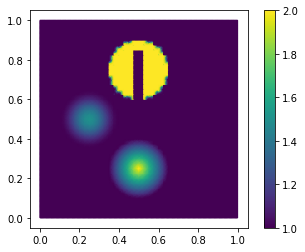

In [33]:

nsp = 16
fn_plotter = FunctionPlotter(mesh, num_sample_points=nsp)

fig, axes = plt.subplots()
axes.set_aspect('equal')
colors = tripcolor(q_init, num_sample_points=nsp, vmin=1, vmax=2, axes=axes)
fig.colorbar(colors)

In [34]:

def animate(q):
    colors.set_array(fn_plotter(q))

# The last step is to make the animation and save it to a file. ::

interval = 1e3 * output_freq * dt
animation = FuncAnimation(fig, animate, frames=qs, interval=interval)
try:
    animation.save("DG1_SSPRK3.mp4", writer="ffmpeg")
except:
    print("Failed to write movie! Try installing `ffmpeg`.")